In [1]:
import numpy as np
import matplotlib.pyplot as plt
sig = np.load('tests/testing_data/signal.npy')
sig.shape
%matplotlib inline

In [2]:
from monai.transforms import SignalResample
from monai.transforms import SignalRandShift
from monai.transforms import SignalRandScale
from monai.transforms import SignalRandDrop
from monai.transforms import SignalRandAddSine
from monai.transforms import SignalRandAddSquarePulse
from monai.transforms import SignalRandAddGaussianNoise
from monai.transforms import Compose

/Users/doursand/opt/anaconda3/envs/monai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
tfs = Compose([SignalResample(method='polynomial',current_sample_rate=500,target_sample_rate=250),
               #SignalRandShift(boundaries=[0,1]),
               #SignalRandScale(v=5,boundaries=[1,5]),
               #SignalRandDrop(v=1,boundaries=[0,0.8]),
               #SignalRandAddSine(v=1,boundaries=[0,1],frequencies=[0.001,0.2]),
               #SignalRandAddSquarePulse(v=1,boundaries=[0,1],frequencies=[0.001,0.2]),
               SignalRandAddGaussianNoise(v=1,boundaries=[0,0.02])
               
               
               ])

In [8]:
tfs(sig).shape

(6, 1000)

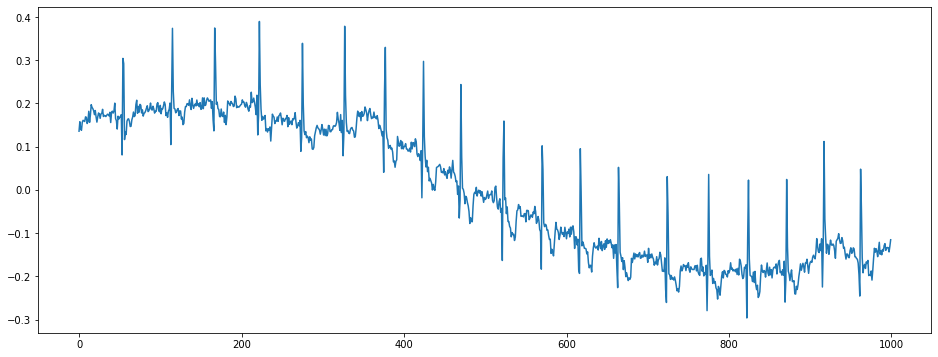

In [11]:
plt.figure(figsize=(16,6))
plt.plot(tfs(sig)[0,:])